### Import Dependencies

In [29]:
from pydantic import BaseModel

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode


from typing import Dict, Literal

from IPython.display import display

from jinja2 import Template
import instructor
from openai import OpenAI

from typing import List

from pydantic import Field
from IPython.display import Image

import inspect
import random

### Simple Single Node Graph

In [16]:
class State(BaseModel):
    message: str
    answer: str = ""
    vibe: str

In [17]:
def append_vibes_to_query(state: State) -> Dict:
    return {"answer": f"{state.message} {state.vibe}"}

In [36]:
workflow = StateGraph(State)

workflow.add_node("append_vibes", append_vibes_to_query)
workflow.add_edge(START, "append_vibes")
workflow.add_edge("append_vibes", END)

graph = workflow.compile()

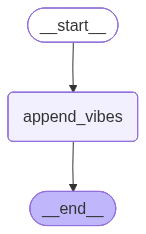

In [37]:
display(graph)

In [38]:
initial_state = {
    "message": "Give me some vibes!",
    "vibe": "I'm feeling like a badass today",
}

In [39]:
result = graph.invoke(initial_state)

In [40]:
result

{'message': 'Give me some vibes!',
 'answer': "Give me some vibes! I'm feeling like a badass today",
 'vibe': "I'm feeling like a badass today"}

### Conditional Graph

In [41]:
class State(BaseModel):
    message: str
    answer: str = ""

In [42]:
def append_vibes_to_query(state: State) -> Dict:
    return {"answer": "I'm here to add some vibes"}

In [43]:
def router(state: State) -> Literal["append_vibe_1", "append_vibe_2", "append_vibe_3"]:
    vibes = ["append_vibe_1", "append_vibe_2", "append_vibe_3"]
    return random.choice(vibes)

In [44]:
def append_vibe_1(state: State) -> Dict:
    vibe = "I'm feeling like a badass today"
    return {"answer": f"{state.answer} {state.message} {vibe}"}


def append_vibe_2(state: State) -> Dict:
    vibe = "I'm feeling like a boss today"
    return {"answer": f"{state.answer} {state.message} {vibe}"}


def append_vibe_3(state: State) -> Dict:
    vibe = "I'm feeling like a legend today"
    return {"answer": f"{state.answer} {state.message} {vibe}"}

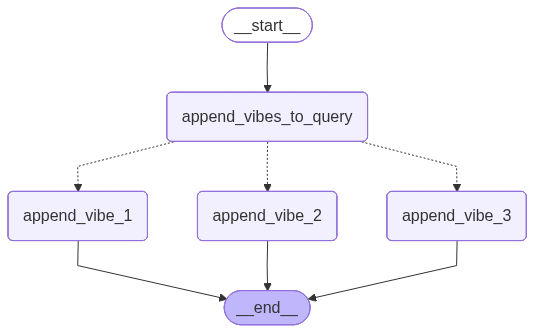

In [45]:
workflow = StateGraph(State)

workflow.add_node("append_vibes_to_query", append_vibes_to_query)
workflow.add_node("append_vibe_1", append_vibe_1)
workflow.add_node("append_vibe_2", append_vibe_2)
workflow.add_node("append_vibe_3", append_vibe_3)


workflow.add_edge(START, "append_vibes_to_query")
workflow.add_conditional_edges("append_vibes_to_query", router)

workflow.add_edge("append_vibe_1", END)
workflow.add_edge("append_vibe_2", END)
workflow.add_edge("append_vibe_3", END)


graph = workflow.compile()
display(graph)

In [46]:
initial_state = {
    "message": "Give me some vibes!",
}

In [58]:
result = graph.invoke(initial_state)

result

{'message': 'Give me some vibes!',
 'answer': "I'm here to add some vibes Give me some vibes! I'm feeling like a legend today"}

### Agent Graph

In [7]:
def append_vibes(query: str, vibe: str) -> str:
    """
    Append vibes to the query
    """
    return f"{query} {vibe}"

In [5]:
import ast
from typing import Dict, Any
from langchain_core.messages import AIMessage


#### FORMAT AI MESSAGE ####


def format_ai_message(response):
    if response.tool_calls:
        tool_calls = []
        for i, tc in enumerate(response.tool_calls):
            tool_calls.append(
                {"id": f"call_{i}", "name": tc.name, "args": tc.arguments}
            )

        ai_message = AIMessage(content=response.answer, tool_calls=tool_calls)
    else:
        ai_message = AIMessage(
            content=response.answer,
        )

    return ai_message


#### TOOL DESCRIPTION PARSING ####


def parse_function_definition(function_def: str) -> Dict[str, Any]:
    """Parse a function definition string to extract metadata including type hints."""
    result = {
        "name": "",
        "description": "",
        "parameters": {"type": "object", "properties": {}},
        "required": [],
        "returns": {"type": "string", "description": ""},
    }

    # Parse the function using AST
    tree = ast.parse(function_def.strip())
    if not tree.body or not isinstance(tree.body[0], ast.FunctionDef):
        return result

    func = tree.body[0]
    result["name"] = func.name

    # Extract docstring
    docstring = ast.get_docstring(func) or ""
    if docstring:
        # Extract description (first line/paragraph)
        desc_end = (
            docstring.find("\n\n") if "\n\n" in docstring else docstring.find("\nArgs:")
        )
        desc_end = desc_end if desc_end > 0 else docstring.find("\nParameters:")
        result["description"] = (
            docstring[:desc_end].strip() if desc_end > 0 else docstring.strip()
        )

        # Parse parameter descriptions
        param_descs = parse_docstring_params(docstring)

        # Extract return description
        if "Returns:" in docstring:
            result["returns"]["description"] = (
                docstring.split("Returns:")[1].strip().split("\n")[0]
            )

    # Extract parameters with type hints
    args = func.args
    defaults = args.defaults
    num_args = len(args.args)
    num_defaults = len(defaults)

    for i, arg in enumerate(args.args):
        if arg.arg == "self":
            continue

        param_info = {
            "type": get_type_from_annotation(arg.annotation)
            if arg.annotation
            else "string",
            "description": param_descs.get(arg.arg, ""),
        }

        # Check for default value
        default_idx = i - (num_args - num_defaults)
        if default_idx >= 0:
            param_info["default"] = ast.literal_eval(ast.unparse(defaults[default_idx]))
        else:
            result["required"].append(arg.arg)

        result["parameters"]["properties"][arg.arg] = param_info

    # Extract return type
    if func.returns:
        result["returns"]["type"] = get_type_from_annotation(func.returns)

    return result


def get_type_from_annotation(annotation) -> str:
    """Convert AST annotation to type string."""
    if not annotation:
        return "string"

    type_map = {
        "str": "string",
        "int": "integer",
        "float": "number",
        "bool": "boolean",
        "list": "array",
        "dict": "object",
        "List": "array",
        "Dict": "object",
    }

    if isinstance(annotation, ast.Name):
        return type_map.get(annotation.id, annotation.id)
    elif isinstance(annotation, ast.Subscript) and isinstance(
        annotation.value, ast.Name
    ):
        base_type = annotation.value.id
        return type_map.get(base_type, base_type.lower())

    return "string"


def parse_docstring_params(docstring: str) -> Dict[str, str]:
    """Extract parameter descriptions from docstring (handles both Args: and Parameters: formats)."""
    params = {}
    lines = docstring.split("\n")
    in_params = False
    current_param = None

    for line in lines:
        stripped = line.strip()

        # Check for parameter section start
        if stripped in ["Args:", "Arguments:", "Parameters:", "Params:"]:
            in_params = True
            current_param = None
        elif stripped.startswith("Returns:") or stripped.startswith("Raises:"):
            in_params = False
        elif in_params:
            # Parse parameter line (handles "param: desc" and "- param: desc" formats)
            if ":" in stripped and (
                stripped[0].isalpha() or stripped.startswith(("-", "*"))
            ):
                param_name = stripped.lstrip("- *").split(":")[0].strip()
                param_desc = ":".join(stripped.lstrip("- *").split(":")[1:]).strip()
                params[param_name] = param_desc
                current_param = param_name
            elif current_param and stripped:
                # Continuation of previous parameter description
                params[current_param] += " " + stripped

    return params


def get_tool_descriptions(function_list):
    """Extract tool descriptions from the function list"""
    descriptions = []

    for function in function_list:
        function_string = inspect.getsource(function)
        result = parse_function_definition(function_string)

        if result:
            descriptions.append(result)

    return descriptions if descriptions else "Could not extract tool descriptions"

In [21]:
from operator import add
from typing import Annotated


class ToolCall(BaseModel):
    name: str
    arguments: Dict


class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)


class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    message: str = ""
    iteration: int = 0
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = []

In [22]:
def agent_node(state: State) -> dict:
    prompt_template = """You are a assistant that is generating vibes for a user.

You will be given a selection of tools you can use to add vibes to a user's query.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Instructions:
- You need to use the tools to add vibes to the user's query.
- Add a random vibe to the user's query.
"""

    template = Template(prompt_template)

    prompt = template.render(available_tools=state.available_tools)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": state.message},
        ],
        temperature=0.5,
    )

    ai_message = format_ai_message(response)

    return {"messages": [ai_message], "tool_calls": response.tool_calls}

In [19]:
get_tool_descriptions([append_vibes])

[{'name': 'append_vibes',
  'description': 'Append vibes to the query',
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string', 'description': ''},
    'vibe': {'type': 'string', 'description': ''}}},
  'required': ['query', 'vibe'],
  'returns': {'type': 'string', 'description': ''}}]

In [23]:
def tool_router(state: State) -> str:
    """
    Decide whether to continue or to end
    """
    if len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"

In [33]:
workflow = StateGraph(State)

tools = [append_vibes]

tool_node = ToolNode(tools)

workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent_node")
workflow.add_conditional_edges(
    "agent_node",
    tool_router,
    {
        "tools": "tool_node",
        "end": END,
    },
)
workflow.add_edge("tool_node", END)

graph = workflow.compile()

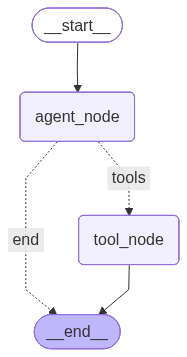

In [34]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
tool_descriptions = get_tool_descriptions([append_vibes])

initial_state = {"message": "Give me some vibes", "available_tools": tool_descriptions}
result = graph.invoke(initial_state)

In [41]:
result

{'messages': [AIMessage(content='Adding some vibes to your request!', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes', 'vibe': 'chill'}, 'id': 'call_0', 'type': 'tool_call'}]),
  ToolMessage(content='Give me some vibes chill', name='append_vibes', tool_call_id='call_0')],
 'message': 'Give me some vibes',
 'available_tools': [{'name': 'append_vibes',
   'description': 'Append vibes to the query',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string', 'description': ''},
     'vibe': {'type': 'string', 'description': ''}}},
   'required': ['query', 'vibe'],
   'returns': {'type': 'string', 'description': ''}}],
 'tool_calls': [ToolCall(name='append_vibes', arguments={'query': 'Give me some vibes', 'vibe': 'chill'})]}

### AgentGraph with Loopback from Tools

In [ ]:
from langchain_core.messages import convert_to_openai_messages


def agent_node(state: State) -> dict:
    prompt_template = """You are a assistant that is generating vibes for a user.

You will be given a selection of tools you can use to add vibes to a user's query.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Instructions:
- You must use the tools to add vibes to the user's query.
- Add a random vibe to the user's query.
- You must return a tool call in the first interaction.
"""

    template = Template(prompt_template)

    prompt = template.render(available_tools=state.available_tools)

    messages = state.messages

    conversation = convert_to_openai_messages(messages)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0.5,
    )

    ai_message = format_ai_message(response)

    return {
        "messages": [ai_message],
        "tool_calls": response.tool_calls,
        "iteration": state.iteration + 1,
        "answer": response.answer,
    }


def tool_router(state: State) -> str:
    """decide whether to continue or to end"""
    if state.iteration > 1:
        return "end"
    elif len(state.tool_calls) > 1:
        return "tools"
    else:
        return "end"

In [46]:
workflow = StateGraph(State)

tools = [append_vibes]

tool_node = ToolNode(tools)

workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent_node")
workflow.add_conditional_edges(
    "agent_node", tool_router, {"tools": "tool_node", "end": END}
)
workflow.add_edge("tool_node", "agent_node")

graph = workflow.compile()

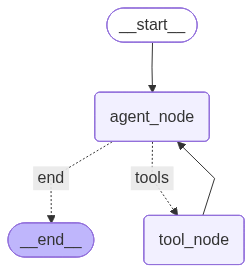

In [47]:
graph

In [50]:
tool_descriptions = get_tool_descriptions([append_vibes])

initial_state = {"message": "Give me some vibes", "available_tools": tool_descriptions}
result = graph.invoke(initial_state)

In [51]:
result

{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Generate vibes for me', 'vibe': 'chill'}, 'id': 'call_0', 'type': 'tool_call'}])],
 'message': 'Give me some vibes',
 'iteration': 1,
 'answer': '',
 'available_tools': [{'name': 'append_vibes',
   'description': 'Append vibes to the query',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string', 'description': ''},
     'vibe': {'type': 'string', 'description': ''}}},
   'required': ['query', 'vibe'],
   'returns': {'type': 'string', 'description': ''}}],
 'tool_calls': [ToolCall(name='append_vibes', arguments={'query': 'Generate vibes for me', 'vibe': 'chill'})]}